# Robust Mean-Variance Optimization Example

Standard Mean-Variance Optimization (MVO) seems perfect in theory, but has a major flaw: it loves estimation error. If an asset got lucky last year, MVO thinks it's a genius investment and bets the farm on it. This makes standard portfolios extremely fragile.

This notebook serves as an example of how to use the code in this package. Instead of assuming our inputs ($\hat{\mu}, \hat{\Sigma}$) are perfect, we build "uncertainty sets" around them and optimize for the **worst-case scenario**. Most of this is based on the formulations in Portfolio Optimization, Theory and Application (2025) by Daniel P. Palomar and the book A Signal Processing Perspective on Financial Engineering (2016) by Daniel P. Palomar and Yiyong Feng.

### The Math
**The Goal:** Maximize utility in the worst-case world:

$$
\begin{aligned}
\max_{w, W, Z} \quad & \underbrace{\left( w^T \hat{\mu} - \kappa \| S_\mu^{1/2} w \|_2 \right)}_{\text{Conservative Return}} - \lambda \cdot \underbrace{\left( \text{Tr}(\hat{\Sigma}(W + Z)) + \epsilon \| P (W + Z) P \|_F \right)}_{\text{Conservative Risk}} \\
\text{s.t.} \quad & \begin{bmatrix} W & w \\ w^T & 1 \end{bmatrix} \succeq 0 \quad (\text{relaxing } W \succeq ww^T) \\
& \sum_{i=1}^N w_i = 1 \\
& w \geq 0 \\
& Z \succeq 0
\end{aligned}
$$

#### Uncertainty Sets Used
The Robust MVO solver is designed to be flexible, allowing you to specify custom uncertainty sets tailored to the specific problem you are solving. In this example, we utilize **Ellipsoidal Uncertainty Sets** for both the mean and covariance, defined as follows:

**1. Mean Uncertainty Set:**
We assume the true mean $\boldsymbol{\mu}$ lies within an ellipsoid centered at the estimate $\hat{\boldsymbol{\mu}}$, scaled by the matrix $\boldsymbol{S}^{1/2}$ (often derived from the standard error of the mean).
$$
\mathcal{U}_{\boldsymbol{\mu}}=\left\{\boldsymbol{\mu}=\hat{\boldsymbol{\mu}}+\kappa \boldsymbol{S}^{1 / 2} \boldsymbol{u} \mid\|\boldsymbol{u}\|_2 \leq 1\right\}
$$

**2. Covariance Uncertainty Set:**
We assume the true covariance $\boldsymbol{\Sigma}$ lies within an ellipsoid defined by the distance metric $\boldsymbol{S}^{-1}$ from the estimate $\hat{\boldsymbol{\Sigma}}$.
$$
\mathcal{U}_{\boldsymbol{\Sigma}}=\left\{\boldsymbol{\Sigma} \succeq \mathbf{0} \mid(\operatorname{vec}(\boldsymbol{\Sigma})-\operatorname{vec}(\hat{\boldsymbol{\Sigma}}))^{\top} \boldsymbol{S}^{-1}(\operatorname{vec}(\boldsymbol{\Sigma})-\operatorname{vec}(\hat{\boldsymbol{\Sigma}})) \leq \epsilon^2\right\}
$$

**What do the Greek letters actually do?**
* $\lambda$ **(Risk Aversion):** How much we hate variance.
* $\kappa$ **(Mean Penalty):** Controls the size of the mean uncertainty ellipsoid ("I don't trust these return estimates").
* $\epsilon$ **(Covariance Penalty):** Controls the radius of the covariance uncertainty set ("I don't trust this correlation matrix").

In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from RobustWorstCasePortfolio.robust_mvo_solvers import robust_mvo_general_ellipsoid
import cvxpy as cp

Now we can compare the performance of the Robust MVO against the Naive MVO using synthetic data.

### Simulation Setup
* **Assets:** 20 synthetic assets with random true means and volatilities.
* **Regime:** Stationary (Training and Test data are drawn from the same distribution).
* **Goal:** We will run **100 Monte Carlo simulations** to see how each strategy performs Out-of-Sample (OOS).

This experiment tests the core hypothesis of Robust Optimization: **Does accounting for parameter uncertainty lead to more consistent and reliable performance?**

Running 100 simulations for 20 assets...


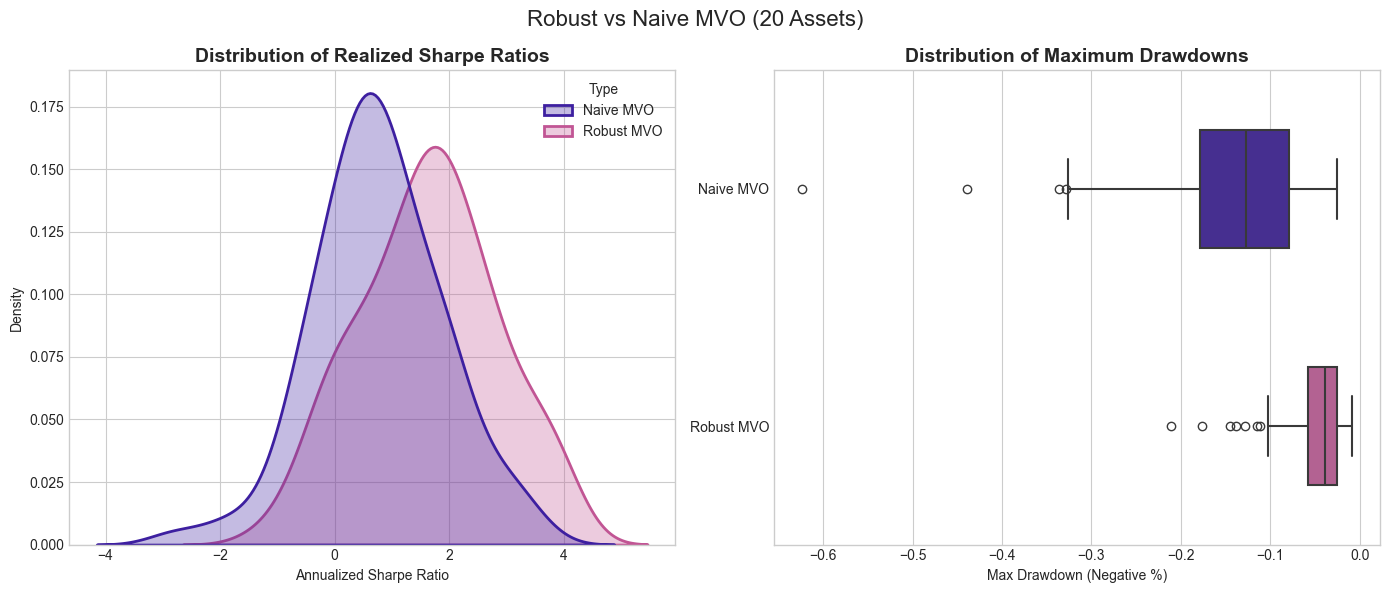

In [ ]:
from HelperFunctions.Functions import sharpe_ratio, max_drawdown

def naive_mvo(mu, Sigma, lam):
    """
    Standard MVO (Utility Maximization) with Long-Only constraints.
    """
    N = len(mu)
    w = cp.Variable(N)
    
    # Utility = Returns - Lambda * Risk
    ret = w.T @ mu
    risk = cp.quad_form(w, Sigma)
    obj = cp.Maximize(ret - lam * risk)
    
    constraints = [
        cp.sum(w) == 1,
        w >= 0
    ]
    
    prob = cp.Problem(obj, constraints)
    try:
        prob.solve(solver=cp.CLARABEL, verbose=False)
    except:
        prob.solve(solver=cp.SCS, verbose=False)
    
    if w.value is None: return np.ones(N)/N
    
    w_final = w.value
    w_final[w_final < 1e-6] = 0
    return w_final / np.sum(w_final)

# simulation setup
np.random.seed(42)
N_SIMULATIONS = 100
T_LOOKBACK = 52  # 1 Year Estimation
T_FORWARD = 52   # 1 Year Test
N_ASSETS = 20    

# Generate Random True Parameters for N_ASSETS
mu_true = np.abs(np.random.randn(N_ASSETS) * 0.001 + 0.002) 
sigma_vec = np.abs(np.random.randn(N_ASSETS) * 0.01 + 0.03)

# Random Correlation Structure
rnd = np.random.randn(N_ASSETS, N_ASSETS)
corr_base = rnd @ rnd.T
D_inv = np.diag(1.0 / np.sqrt(np.diag(corr_base)))
corr = D_inv @ corr_base @ D_inv
Sigma_true = np.outer(sigma_vec, sigma_vec) * corr

# Robust Parameters
LAMBDA = 2.0
EPSILON = 0.01
KAPPA = 0.5     
Q_COV = np.eye(N_ASSETS) # P_shape

results = []
print(f"Running {N_SIMULATIONS} simulations for {N_ASSETS} assets...")

for i in range(N_SIMULATIONS):
    # 1. Generate Historical Data (In-Sample)
    returns_hist = np.random.multivariate_normal(mu_true, Sigma_true, T_LOOKBACK)
    mu_est = np.mean(returns_hist, axis=0)
    Sigma_est = np.cov(returns_hist, rowvar=False)
    S_mu = Sigma_est / T_LOOKBACK

    # 2. Solve Portfolios
    w_naive = naive_mvo(mu_est, Sigma_est, LAMBDA)
    w_robust = robust_mvo_general_ellipsoid(mu_est, Sigma_est, LAMBDA, EPSILON, KAPPA, S_mu, Q_COV)
        
    # 3. Test Out-of-Sample
    returns_oos = np.random.multivariate_normal(mu_true, Sigma_true, T_FORWARD)
    
    r_naive = returns_oos @ w_naive
    r_robust = returns_oos @ w_robust
    
    results.append({'Type': 'Naive MVO', 'Sharpe': sharpe_ratio(r_naive), 'MaxDrawdown': max_drawdown(r_naive)})
    results.append({'Type': 'Robust MVO', 'Sharpe': sharpe_ratio(r_robust), 'MaxDrawdown': max_drawdown(r_robust)})

df_res = pd.DataFrame(results)

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
palette = {'Naive MVO': "#3d1fa0", 'Robust MVO': "#c15594"}

sns.kdeplot(data=df_res, x='Sharpe', hue='Type', fill=True, 
            alpha=0.3, linewidth=2, palette=palette, ax=axes[0])
axes[0].set_title('Distribution of Realized Sharpe Ratios', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Density')
axes[0].set_xlabel('Annualized Sharpe Ratio')

sns.boxplot(data=df_res, x='MaxDrawdown', y='Type', hue='Type', legend=False, orient='h', 
            palette=palette, width=0.5, linewidth=1.5, ax=axes[1])
axes[1].set_title('Distribution of Maximum Drawdowns', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Max Drawdown (Negative %)')
axes[1].set_ylabel('')

plt.suptitle(f'Robust vs Naive MVO ({N_ASSETS} Assets)', fontsize=16)
plt.tight_layout()
plt.show()

Furthermore, we can also look at the weight distributions to see how robustness affects portfolio concentration:

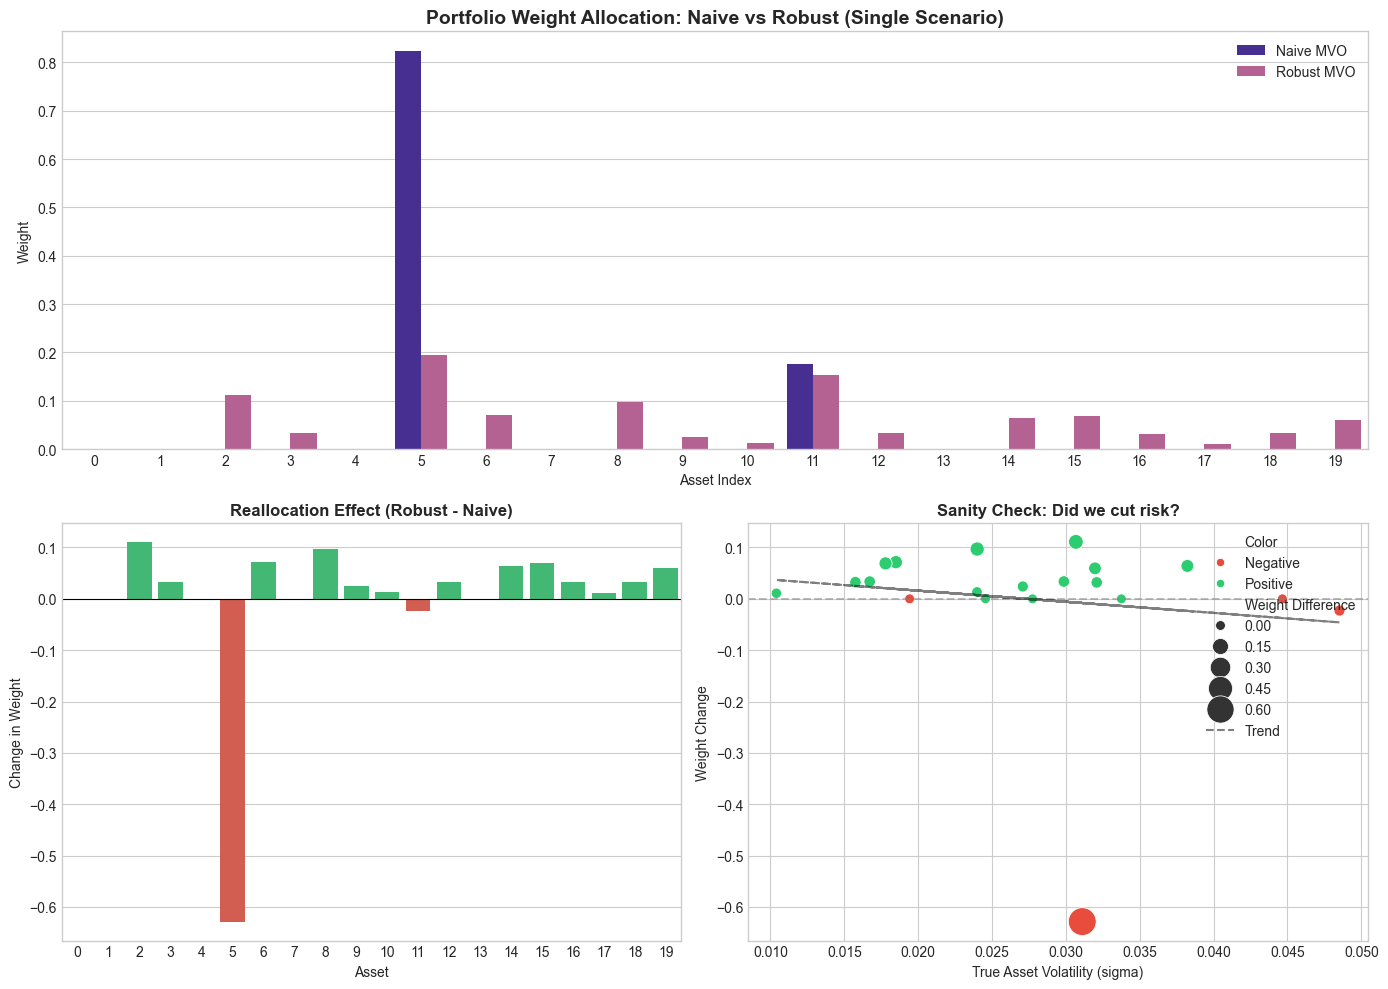

In [ ]:
np.random.seed(42) 
N_ASSETS = 20
T_LOOKBACK = 52

mu_true = np.abs(np.random.randn(N_ASSETS) * 0.001 + 0.002) 
sigma_vec = np.abs(np.random.randn(N_ASSETS) * 0.01 + 0.03)

# Random Correlation Structure
rnd = np.random.randn(N_ASSETS, N_ASSETS)
corr_base = rnd @ rnd.T
D_inv = np.diag(1.0 / np.sqrt(np.diag(corr_base)))
corr = D_inv @ corr_base @ D_inv
Sigma_true = np.outer(sigma_vec, sigma_vec) * corr

# Parameters
LAMBDA = 2.0
EPSILON = 0.01
KAPPA = 0.5
Q_COV = np.eye(N_ASSETS)

returns_viz = np.random.multivariate_normal(mu_true, Sigma_true, T_LOOKBACK)
mu_viz = np.mean(returns_viz, axis=0)
Sigma_viz = np.cov(returns_viz, rowvar=False)
S_mu_viz = Sigma_viz / T_LOOKBACK

# Solve for weights
w_naive_viz = naive_mvo(mu_viz, Sigma_viz, LAMBDA)
w_robust_viz = robust_mvo_general_ellipsoid(mu_viz, Sigma_viz, LAMBDA, EPSILON, KAPPA, S_mu_viz, Q_COV)

assets = np.arange(N_ASSETS)
df_weights = pd.DataFrame({
    'Asset': np.tile(assets, 2),
    'Weight': np.concatenate([w_naive_viz, w_robust_viz]),
    'Type': ['Naive MVO'] * N_ASSETS + ['Robust MVO'] * N_ASSETS
})

diff = w_robust_viz - w_naive_viz
df_diff = pd.DataFrame({
    'Asset': assets,
    'Weight Difference': diff,
    'True Volatility': sigma_vec,
    'Color': ['Positive' if x > 0 else 'Negative' for x in diff]
})

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2)

# Side-by-side weights comparison
ax1 = fig.add_subplot(gs[0, :])
sns.barplot(data=df_weights, x='Asset', y='Weight', hue='Type', 
            palette={'Naive MVO': "#3d1fa0", 'Robust MVO': "#c15594"}, ax=ax1)
ax1.set_title('Portfolio Weight Allocation: Naive vs Robust (Single Scenario)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Weight')
ax1.set_xlabel('Asset Index')
ax1.legend(loc='upper right')

# Net weight change
ax2 = fig.add_subplot(gs[1, 0])
sns.barplot(data=df_diff, x='Asset', y='Weight Difference', hue='Color', 
            palette={'Positive': "#2ecc71", 'Negative': "#e74c3c"}, dodge=False, ax=ax2)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_title('Reallocation Effect (Robust - Naive)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Change in Weight')
ax2.legend().remove()

# Weight change vs True Asset Volatility
ax3 = fig.add_subplot(gs[1, 1])
sns.scatterplot(data=df_diff, x='True Volatility', y='Weight Difference', 
                size=np.abs(df_diff['Weight Difference']), sizes=(50, 400), 
                hue='Color', palette={'Positive': "#2ecc71", 'Negative': "#e74c3c"}, ax=ax3)
ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)

z = np.polyfit(df_diff['True Volatility'], df_diff['Weight Difference'], 1)
p = np.poly1d(z)
ax3.plot(df_diff['True Volatility'], p(df_diff['True Volatility']), "k--", alpha=0.5, label='Trend')

ax3.set_title('Sanity Check: Did we cut risk?', fontsize=12, fontweight='bold')
ax3.set_xlabel('True Asset Volatility (sigma)')
ax3.set_ylabel('Weight Change')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()